This notebook is an implementation of the following paper:

**Federated Learning for Cellular-connected UAVs: Radio Mapping and Path Planning**

presented in IEEE Globecom 2020.

Link to paper: https://arxiv.org/abs/2008.10054

By: Behzad Khamidehi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [2]:
from collections import namedtuple
import warnings
# warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)

Transition = namedtuple('Transition',('point', 'rss_target'))


batch_size = 1000
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Network Configuration:

The following figure shows the network configuration and the distribution of the ground base stations (GBSs).

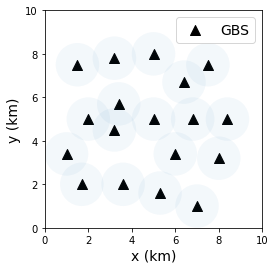

In [27]:
fig, ax = plt.subplots()
x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
for i in range(len(x)):
  ax.add_patch(plt.Circle((x[i], y[i]), 1, alpha=0.05))

plt.scatter(x,y, marker = "^", s = 100, c = 'k', alpha=1, label = 'GBS')
plt.xlabel('x (km)',fontsize=14)
plt.xlim(0,10)
plt.ylabel('y (km)',fontsize=14)
plt.ylim(0,10)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(False)
plt.legend(fontsize=14)
plt.savefig('GBS.pdf',format = 'pdf')
ax.plot()   #Causes an autoscale update.
plt.show()

## Agent

Now, we create the agent class. This class specifies the flight area, the air2ground communiocation channel between the agent and the GBSs, and the movement of the agent. The initial position of the agent is randomly chosen.  

In [28]:
class Agent(object):
  def __init__(self, X_min, X_max, Y_min, Y_max, replay_buffer_size, batch_size, thr):
    self.X_min = X_min
    self.X_max = X_max
    self.Y_min = Y_min
    self.Y_max = Y_max
    self.batch_size = batch_size
    self.thr = thr

    self.UAV_position = [0,0]
    self.UAV_position[0] = self.X_min + (self.X_max - self.X_min)*np.random.rand()
    self.UAV_position[1] = self.Y_min + (self.Y_max - self.Y_min)*np.random.rand()


    self.memory = ReplayMemory(replay_buffer_size)

  def move(self, r):
    theta = 2*np.pi * np.random.rand()
    self.UAV_position[0] = self.UAV_position[0] + r*np.cos(theta)
    self.UAV_position[1] = self.UAV_position[1] + r*np.sin(theta)
    if self.UAV_position[0] < self.X_min:
      self.UAV_position[0] = self.X_min
    elif self.UAV_position[0] > self.X_max:
      self.UAV_position[0] = self.X_max

    if self.UAV_position[1] < self.Y_min:
      self.UAV_position[1] = self.Y_min
    elif self.UAV_position[1] > self.Y_max:
      self.UAV_position[1] = self.Y_max

    XY = np.zeros(2)
    XY[0] = self.UAV_position[0]
    XY[1] = self.UAV_position[1]
    return XY
    


  def reset(self):
    self.UAV_position = [0,0]
    self.UAV_position[0] = self.X_min + (self.X_max - self.X_min)*np.random.rand()
    self.UAV_position[1] = self.Y_min + (self.Y_max - self.Y_min)*np.random.rand()


  def get_rss_target(self):
    point = self.UAV_position
    P = 0.2
    x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
    y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
    BS = {}
    rss = {}
    for b in range(len(x)):
      BS[b] = np.zeros((2))
      BS[b][0] = x[b]
      BS[b][1] = y[b]
      rss[b] = np.zeros(1)
  
    RSS =np.zeros(1)
    
    for b in BS.keys():
      distance = (np.linalg.norm(point-BS[b]))**2 + 0.01
      rss[b] = np.divide(P*random.random(), (84*84*1000*1000*distance) )
    temp_var = np.sum([rss[b] for b in BS.keys()])
    RSS = max([ rss[b]/(temp_var - rss[b] +10**(-14) ) for b in BS.keys()  ])
    RSS = np.float32(RSS)
    #RSS = torch.tensor(RSS)
    RSS_target = int(0)
    if RSS > self.thr:
      RSS_target = 1
    else:
      RSS_target = 0 
    return np.array([RSS_target])  



  def store_transition(self, point, rss_target):
    point = torch.from_numpy(point).float()
    rss_target = torch.from_numpy(rss_target).long()
    self.memory.push(point, rss_target)



  def get_batch(self):
    if len(self.memory) < self.batch_size:
      return
    transitions = self.memory.sample(self.batch_size)
    batch = Transition(*zip(*transitions))
    Points = torch.stack(batch.point)
    RSS_target = torch.stack(batch.rss_target)
    return Points.squeeze(), RSS_target.squeeze()

Creating a sample agent:

In [ ]:
UAV = Agent(0, 10, 0, 10, 100000, 30, 0.65)
for i in range(1000):
  UAV.reset()
  point = UAV.move(0.5)
  rss_target = UAV.get_rss_target()
  UAV.store_transition(point,rss_target)
Points, RSS_target = UAV.get_batch()

print(RSS_target)

As described in the paper, this project has two parts:

- Radio mapping

- Path planning.

For the radio mapping, we use a distributed learning algorithm (Federated Learning) to train a neural network that predicts the RSS in the area. Using this approach, the agents do not need to communicate directly. Also, we can use the data sets of all agents. 



# **Part 1- Radio Mapping**

## **Neural Network:**

Here, we define the Neural Network which is used to generate the global outage model in the *sky*.

In [29]:
class DNN(nn.Module):
    def __init__(self, n_hidden):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(2, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc5 = nn.Linear(n_hidden, 2)

    def forward(self, x):
        z = F.relu(self.fc1(x))
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        output = F.softmax(self.fc5(z))
        return output

In the Federated Learninng architecture, we have a number of workers and an aggregator. Here, we implement their functionalities:

In [30]:
def worker_update(worker_model, optimizer, Points, RSS_targets, epoch):
  running_loss = 0
  for e in range(epoch):
    optimizer.zero_grad()
    outputs = worker_model(Points)
    loss = criterion(outputs, RSS_target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss


def server_aggregate(global_model, worker_models):
  global_dict = global_model.state_dict()
  for k in global_dict.keys():
    global_dict[k] = torch.stack([worker_models[i].state_dict()[k] for i in range(len(worker_models))], 0).mean(0)
  global_model.load_state_dict(global_dict)
  for model in worker_models:
    model.load_state_dict(global_model.state_dict())

In [31]:
num_workers = 5

global_model = DNN(n_hidden = 256) # Global model
worker_models = [DNN(n_hidden = 256) for _ in range(num_workers)]
for model in worker_models:
    model.load_state_dict(global_model.state_dict())
    # Broadcast the global model to the workers

criterion = nn.CrossEntropyLoss()
optimizer = [optim.Adam(model.parameters()) for model in worker_models]



##  **Main Training Loop:**

In [ ]:
#main:
thr = .65
UAV = [Agent(0, 10, 0, 10, 100000, batch_size, thr) for _ in range(num_workers)]

num_rounds = 500
epochs = 10
n_samples = batch_size

Avg_Loss_rounds = np.zeros(num_rounds) 
loss = np.zeros(num_workers)
loss_rounds = np.zeros((num_rounds,num_workers))
#Points, RSS_target = data_generator(n_samples,thr )
Data = {}
for w in range(num_workers):
  Data[w]={}
  Data[w]['Points'] = [] 
  Data[w]['RSS_target'] = []

for r in range(num_rounds):
  for w in range(num_workers):
    UAV[w].reset()
    for h in range(n_samples):
      point = UAV[w].move(0.1)
      rss_target = UAV[w].get_rss_target()
      UAV[w].store_transition(point, rss_target)

    Points, RSS_target = UAV[w].get_batch()
    Data[w]['Points'] = Points 
    Data[w]['RSS_target'] = RSS_target
    loss[w] += worker_update(worker_models[w], optimizer[w], Data[w]['Points'], Data[w]['RSS_target'], epoch=epochs)


    loss_rounds[r,w] = np.copy(loss[w])#/((r+1)*epochs)


    
    # server aggregate
  server_aggregate(global_model, worker_models)
  Avg_Loss_rounds[r] = (np.mean(loss_rounds[r,:]))/((r+1)*epochs)
  if r%10 == 0:
    print('round number: { }, avg_loss: {}'.format(r, Avg_Loss_rounds[r]))


Based on the output of the trained neural network, we can obtain the outage probability in each point of the environment. the coordinates of these points are (x,y,H)

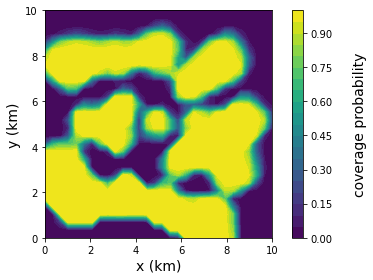

In [36]:
M=30
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)
probb = np.zeros((M,M))

with torch.no_grad():
  for ii in range(M):
    for jj in range(M):
      a = np.float32([ x[ii], y[jj] ])#.tolist()    
      probb[ii,jj] = global_model(torch.tensor(a))[0]



plt.figure(tight_layout=True)
probb = probb.T
plt.contourf(x,y,1- probb, 20)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar()
cbar.set_label('coverage probability',labelpad=20, rotation=90,fontsize=14) 
plt.xlabel('x (km)',fontsize=14)
plt.ylabel('y (km)',fontsize=14)

#x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
#y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
#plt.scatter(x,y, marker = "^", s = 20, c = 'k', alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Outage.eps',format = 'eps')
plt.show()


# **Part 2- Path Planning**

The second part of the project is to design proper paths for the agents based on the resulting coverage model. For this purpose, we use RRT*, which is asampling-based path planning algorithm.

### **RRT-star**
After generating the global model of the outage probability in the sky, we can use RRT* to obtain proper paths for the UAVs. 


In what follows, I present the code for the RRT* algorithm:

In [43]:
class Node:
  def __init__(self, coord, parent, cost):
    
    self.coord = coord
    self.parent = parent
    self.cost = cost

class RRT:
  def __init__(self,model):
    self.model = model
    self.nodes = {}
    self.q_start = Node([4, 8],0,0)
    self.q_goal = Node([8.5,8], None, 0)


  def steer(self,qr, qn, val, eps):
    qnew = [0,0]
    if val >= eps:
      dist = np.linalg.norm (np.subtract(qr,qn))
      qnew[0] = qn[0] + ((qr[0] - qn[0])*eps)/dist
      qnew[1] = qn[1] + ((qr[1] - qn[1])*eps)/dist
    else:
      qnew[0] = qr[0]
      qnew[1] = qr[1]
    return [qnew[0],qnew[1]]




  def constraints(self,n2,n1):
    # if satisfied return True
    a = np.float32(n2)
    b = np.float32(n1)
    #a = np.float32([ x[ii], y[jj] ])#.tolist()    
    prob_1= self.model(torch.tensor(a))[1]
    prob_2= self.model(torch.tensor(b))[1]
    if prob_1 > 0.5 and prob_2 >0.5:
      return True
    else:
      return False

Algorithm:

In [ ]:
num_Nodes = 3000
x_max = 5
y_max = 5
#EPS = 0.05
EPS = 0.1
r=0.2

rrt = RRT(model)
rrt.nodes[0] = rrt.q_start
plt.figure()
for n in range(num_Nodes):
  q_rand = [5 + random.random()*x_max, 5 + random.random()*y_max ]
  #plt.scatter(q_rand[0],q_rand[1], c = 'k', s = 10)
  for j in range(len(rrt.nodes.keys())):
    if np.linalg.norm( np.subtract(rrt.nodes[j].coord,rrt.q_goal.coord) ) < 0.5:
      break
  
  ndist = []
  for j in range(len(rrt.nodes.keys())):
    n = rrt.nodes[j];
    tmp = np.linalg.norm( np.subtract(n.coord, q_rand) );
    ndist.append(tmp)
  val = np.min(ndist)
  idx = np.argmin(ndist)
  q_near = rrt.nodes[idx]
  q_new = Node(None, None, None)
  q_new.coord = rrt.steer(q_rand, q_near.coord, val, EPS);
  if rrt.constraints(q_rand, q_near.coord):
    plt.plot([q_near.coord[0], q_new.coord[0]], [q_near.coord[1], q_new.coord[1]], c = 'b' )
    q_new.cost = np.linalg.norm(np.subtract(q_new.coord , q_near.coord)) + q_near.cost;


    q_nearest = {}
    
    neighbor_count = 0
    for j in range(len(rrt.nodes.keys())):
      if rrt.constraints( rrt.nodes[j].coord , q_new.coord ) and np.linalg.norm( np.subtract( rrt.nodes[j].coord , q_new.coord )) <= r:
        q_nearest[neighbor_count] = Node(None, None, None)
        q_nearest[neighbor_count].coord = rrt.nodes[j].coord
        q_nearest[neighbor_count].cost = rrt.nodes[j].cost
        neighbor_count +=1

    q_min = q_near
    C_min = q_new.cost
    #print(q_nearest[0].cost)
    for k in range(len(q_nearest.keys())):
      if rrt.constraints(q_nearest[k].coord, q_new.coord) and (q_nearest[k].cost + np.linalg.norm( np.subtract(q_nearest[k].coord,q_new.coord)) < C_min):
        q_min = q_nearest[k]
        C_min = q_nearest[k].cost + np.linalg.norm( np.subtract( q_nearest[k].coord, q_new.coord ) ) 
        plt.plot([q_min.coord[0], q_new.coord[0]], [q_min.coord[1], q_new.coord[1]], c = 'g')

    for j in range(len(rrt.nodes.keys())):
      if rrt.nodes[j].coord[0] == q_min.coord[0] and rrt.nodes[j].coord[1] == q_min.coord[1]:
        q_new.parent = j
    
    l = len(rrt.nodes.keys())
    rrt.nodes[l] = q_new


D = []
for j in range(len(rrt.nodes.keys())):
    tmpdist = np.linalg.norm(np.subtract(rrt.nodes[j].coord, rrt.q_goal.coord ) ) 
    D.append(tmpdist)

#search backward
val = np.min(D)
idx = np.argmin(D)

q_final = rrt.nodes[idx]
rrt.q_goal.parent = idx
q_end = rrt.q_goal
l = len(rrt.nodes.keys())
rrt.nodes[l] = rrt.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt.nodes[start].coord[0]] , [q_end.coord[1], rrt.nodes[start].coord[1]] , c = 'r',linewidth=2 )

  q_end = rrt.nodes[start]


Sample result:

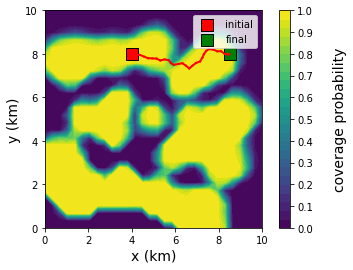

In [45]:
M=30
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)

#PROB = 0.5*(P1+P2) 
PROB = probb
plt.contourf(x,y,1 - PROB, 30)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v)
cbar.set_label('coverage probability',labelpad=20, rotation=90,fontsize=14) 
plt.xlabel('x (km)',fontsize=14)
plt.ylabel('y (km)',fontsize=14)


plt.gca().set_aspect('equal', adjustable='box')

#search backward
val = np.min(D)
idx = np.argmin(D)
#rrt.q_goal.coord = [9,8]
q_final = rrt.nodes[idx]
rrt.q_goal.parent = idx
q_end = rrt.q_goal
l = len(rrt.nodes.keys())
rrt.nodes[l] = rrt.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt.nodes[start].coord[0]] , [q_end.coord[1], rrt.nodes[start].coord[1]] , c = 'r',linewidth=2, )

  q_end = rrt.nodes[start]



plt.scatter(rrt.q_start.coord[0],rrt.q_start.coord[1], marker = 's',ec = 'k', s=140, c = 'red', label = 'initial')
plt.scatter(rrt.q_goal.coord[0],rrt.q_goal.coord[1], marker = 's', ec = 'k',  s=140, c = 'g', label ='final')
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend(loc ='best')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('T2.pdf',format = 'pdf')
plt.show()